# SETUP
---

## import packages

In [1]:
import pandas as pd
import numpy as np
import time
import glob

from fastparquet import ParquetFile

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture

print('--- packages imported ---')

--- packages imported ---


## set plot style

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to set plot style if no arguments provided
jtplot.style()

print('--- jtplot.style() initialized    --')
print('--- theme plot style will be used ---')

--- jtplot.style() initialized    --
--- theme plot style will be used ---


## define constants

In [3]:
VERBOSE = True
DEBUG = False
#COLORS = sns.husl_palette(21)
#COLORS = ['r','g','b','y']
COLORS = ["r","g","y","m","w","b","c","limegreen",'tab:orange','tab:pink','tab:cyan','tab:olive','tab:green','tab:blue','tab:red','tab:purple',
         'firebrick','tomato','aqua','dodgerblue','lime']

print('--- constants initialized ---')

--- constants initialized ---


## load dataset

In [4]:
df_orders_pvt = pd.read_csv('instacart_order_pivot.csv')
df_orders_pvt = df_orders_pvt.sort_values(by=['user_id','order_number']).reset_index().drop(['index'], axis=1)# TODO do in PySpark
print(df_orders_pvt.shape)
df_orders_pvt.tail()

(3292455, 30)


,order_id,user_id,eval_set,order_number,order_dow,order_hour,d1,d2,d3,d4,...,d15,d16,d17,d18,d19,d20,d21,days_elapsed,reord1,num_items
3292450,2266710,206209,prior,10,5,18,1,0,1,1,...,0,1,1,0,1,0,0,29.0,3,9
3292451,1854736,206209,prior,11,4,10,0,0,1,1,...,0,2,1,0,1,1,0,30.0,6,8
3292452,626363,206209,prior,12,1,12,0,0,2,5,...,0,4,3,0,1,1,0,18.0,14,20
3292453,2977660,206209,prior,13,1,12,0,0,0,1,...,0,2,0,0,4,0,0,7.0,4,9
3292454,272231,206209,train,14,6,14,1,0,1,1,...,0,1,1,0,1,0,0,30.0,4,8


# HELPER FUNCTIONS
---

## plotting functions

In [5]:
# umap dimensionality reduction
def run_umap(X, neighbors=5, dist=0.1):
    time_start = time.time()
    print('UMAP start...')
    umap_results = umap.UMAP(n_neighbors=neighbors, min_dist=dist, metric='correlation').fit_transform(X)
    print(f'UMAP completed in {(time.time()-time_start):.6f} seconds!\n')
    return umap_results

print('--- run_umap() defined ---')

# pca dimensionality reduction
def run_pca(X):
    time_start = time.time()
    print('PCA start...')
    pca = PCA(n_components=2).fit_transform(X)
    print(f'PCA completed in {(time.time()-time_start):.6f} seconds!\n')
    return pca

print('--- run_pca() function defined ---')

--- run_umap() defined ---
--- run_pca() function defined ---


In [6]:
def plot_elbow_method(inertia, k_range=range(2,11)):
    print('--- plot_elbow_method() ---')
    time_start = time.time()
    
    plt.rcParams['figure.figsize'] = (8,4)

    plt.plot(k_range , inertia , 'o')
    plt.plot(k_range , inertia , '-' , alpha = 0.5)

    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Choosing k\nElbow Method', fontsize=20)

    plt.tight_layout()
    plt.show()
    print(f'--- plot_elbow_method() completed in {time.time()-time_start:.4f} seconds')
    
print('--- plot_elbow_method() function defined ---')

--- plot_elbow_method() function defined ---


In [7]:
def plot_2D(data, y=None):
    print(f'--- plot_2D() ---')
    time_start = time.time()
    
    colors = COLORS
    
    # plot data points with color grouping
    if y is not None:
        df_tmp = pd.concat([pd.DataFrame(data),pd.DataFrame(y)], axis=1)
        df_tmp.columns = ['x','y','cluster']
        
        if DEBUG:
            print(df_tmp.cluster.unique())
        
        for i in df_tmp.cluster.unique():
            plt.scatter(df_tmp[df_tmp.cluster == i].x, df_tmp[df_tmp.cluster == i].y, color = colors[i])
            
    # plot data points without color grouping
    else:
        plt.scatter(data[:, 0], data[:, 1])

    # disabling axes
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    print(f'--- plot_2D() completed in {(time.time()-time_start):.6f} seconds! ---')

print('--- plot_2D() function defined --- ')

--- plot_2D() function defined --- 


In [8]:
def silhouette_plot(cluster_labels, x, k):
    print(f'--- silhouette_plot() ---')
    func_start = time.time()
    
    if VERBOSE:
        print(f'\t--- cluster_solution = {set(list(cluster_labels))}')

    # calculate silhouette average across all samples
    silhouette_avg = silhouette_score(x, cluster_labels)
    print(f'\t--- calculated silhouette average across all samples ({silhouette_avg:.6f}) in {time.time()-func_start} seconds ---')
    time_start = time.time()
    
    # calculate silhouette score for each sample
    silhouette_sam = silhouette_samples(x, cluster_labels)
    print(f'\t--- calculated silhouette score for each sample in {time.time()-time_start} seconds ---')
    
    y_lower = 10
    
    # iterate through each cluster
    for i in range(k):
        loop_start = time.time()

        # select the samples for each cluster i
        cluster_silhouette_vals = silhouette_sam[cluster_labels == i]
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: select the samples for cluster {i} ---')
        
        # sort the cluster's per-sample silhouette coefficients
        cluster_silhouette_vals.sort()
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: sort the clusters per-sample silhouette coefficients for cluster {i} ---')
        
        # define cluster size (for plotting)
        cluster_size = cluster_silhouette_vals.shape[0]

        y_upper = y_lower + cluster_size
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: define cluster size for cluster {i} ---')
        
        # define color for then plot each cluster
        color = COLORS[i]
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: plotting silhouette plot for cluster {i} ---')
        
        # label cluster at the y-midpoint of the cluster
        plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
        
        # compute y_lower for next cluster
        y_lower = y_upper + 10
        
        if DEBUG:
            print(f'\t--- {time.time()-loop_start:.2f} seconds: cluster {k} ---')
            
    # plot silhouette average
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # plot labeling options
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster Label')
    plt.xticks(np.arange(-0.5, 0.7, 0.1))
    plt.yticks([])
    plt.title(f'Silhouette Plot for {k} Clusters')
    
    print(f'--- silhouette_plot() completed in {time.time()-func_start:.4f} seconds ---')
    
print('--- silhouette_plot() function defined ---')

--- silhouette_plot() function defined ---


## cluster analysis functions

In [9]:
def elbow_method(x, k_range=range(2,11), mini=False):
    print('--- elbow_method() ---')
    func_start = time.time()
    
    inertia = []
    for k in k_range:
        time_start = time.time()
        if mini:
            kmeans_ = MiniBatchKMeans(n_clusters=k, random_state=123).fit(x)
        else:
            kmeans_ = KMeans(n_clusters=k, random_state=123).fit(x)
        inertia.append(kmeans_.inertia_)
        if VERBOSE:
            print(f'\t--- {time.time()-time_start:.2f} seconds: k={k} ---')
    
    print(f'--- elbow_method() completed in {time.time()-func_start:.4f} seconds ---')
        
    return inertia

print('--- elbow_method() function defined ---')

--- elbow_method() function defined ---


In [10]:
def silhouette_analysis(x, cluster_range=range(3,6), algo='KMEANS', reduced_results=None, dbscan_eps=1.1, dbscan_min_samples=10, dbscan_clusters=2):
    print('--- silhouette_analysis() ---')
    func_start = time.time()
    
    # set figure size
    plt.rcParams['figure.figsize'] = (16,16)

    # define cluster range
    if algo == 'DBSCAN':
        clusters = range(dbscan_clusters,dbscan_clusters+1)
    else:
        clusters = cluster_range

    count = 1
    # try multiple num cluster values
    for k in clusters:
        loop_start_ = time.time()
        
        # select clusterer
        if algo == 'GMM':
            clusterer = GaussianMixture(n_components=k, random_state=123)
        elif algo == 'AGGLOMERATIVE-1':
            clusterer = AgglomerativeClustering(linkage='complete', affinity='cosine', n_clusters=k)
        elif algo == 'AGGLOMERATIVE-2':
            clusterer = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=k)
        elif algo == 'AGGLOMERATIVE-3':
            clusterer = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=k)
        elif algo == 'AGGLOMERATIVE-4':
            clusterer = AgglomerativeClustering(linkage='average', affinity='euclidean', n_clusters=k)
        elif algo == 'DBSCAN':
            clusterer = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
        elif algo =='MINIBATCHKMEANS':
            clusterer = MiniBatchKMeans(n_clusters=k, random_state=123)
        else:
            clusterer = KMeans(n_clusters=k, random_state=123, n_jobs=4)
        
        # get cluster labels
        cluster_labels = clusterer.fit_predict(x)

        # silhouette plot
        plt.subplot(5,2,count)
        silhouette_plot(cluster_labels, x, k)
        count += 1

        # cluster plots
        plt.subplot(5,2,count)
        plot_2D(reduced_results, cluster_labels)
        count += 1
        
        if VERBOSE:
            print(f'\t--- {k}-cluster silhouette analysis completed in {time.time()-loop_start_:.4f} seconds ---')
    
    plt.suptitle(f'Silhouette Analysis with {algo} Clusterer', y=1.05, fontsize=20)
    plt.tight_layout()
    plt.show()
    print(f'--- silhouette analysis() completed in {time.time()-func_start:.4f} seconds ---')
    
print('--- silhouette_analysis function defined ---')

--- silhouette_analysis function defined ---


# CLUSTERING
---

## define model

In [11]:
def group_days(x):
    if x > 1:
        return 'WEEKDAY'
    return 'WEEKEND'

def group_time(x):
    if x > 8 and x < 17:
        return 'PEAK'
    elif x <= 8:
        return 'PRE-PEAK'
    else:
        return 'POST-PEAK'
    
def group_order_number(x):
    if x <= 4:
        return 'Q25'
    if x <= 10:
        return 'Q50'
    if x <= 23:
        return 'Q75'
    return 'Q100'

# select features for the model
df_model = df_orders_pvt.drop(['order_id','user_id','eval_set'], axis=1).copy()

# group order_dow
df_model['ORDER_DAY'] = df_model.order_dow.apply(group_days)

# group order_hour
df_model['ORDER_TIME'] = df_model.order_hour.apply(group_time)

# group order_number
df_model['ORDER_NUMBER'] = df_model.order_number.apply(group_order_number)

# drop original ungrouped columns
df_model = df_model.drop(['order_dow','order_hour','order_number'], axis=1)

# define departments to drop
dept_drop = df_orders_pvt.loc[:,'d1':'d21'].drop(['d4','d16'], axis=1).columns.to_list()
dept_drop

# drop departments that correlate < 0.5 with num_items
df_model = df_model.drop(dept_drop, axis=1)

print(df_model.shape)
df_model.head()

(3292455, 8)


,d4,d16,days_elapsed,reord1,num_items,ORDER_DAY,ORDER_TIME,ORDER_NUMBER
0,0,1,0.0,0,5,WEEKDAY,PRE-PEAK,Q25
1,1,0,15.0,3,6,WEEKDAY,PRE-PEAK,Q25
2,0,1,21.0,3,5,WEEKDAY,PEAK,Q25
3,0,1,29.0,5,5,WEEKDAY,PRE-PEAK,Q25
4,4,1,28.0,5,8,WEEKDAY,PEAK,Q50


In [12]:
#df_model.to_csv('instacart_unsupervised_model_11_features_pre-one-hot-encoding.csv', index=False)

In [13]:
# one-hot encoding
X = pd.get_dummies(df_model, drop_first=True)
print(X.shape)
X.head()

(3292455, 11)


,d4,d16,days_elapsed,reord1,num_items,ORDER_DAY_WEEKEND,ORDER_TIME_POST-PEAK,ORDER_TIME_PRE-PEAK,ORDER_NUMBER_Q25,ORDER_NUMBER_Q50,ORDER_NUMBER_Q75
0,0,1,0.0,0,5,0,0,1,1,0,0
1,1,0,15.0,3,6,0,0,1,1,0,0
2,0,1,21.0,3,5,0,0,0,1,0,0
3,0,1,29.0,5,5,0,0,1,1,0,0
4,4,1,28.0,5,8,0,0,0,0,1,0


In [49]:
#X.to_csv('instacart_unsupervised_model_11_features_post_one_hot_encoding.csv', index=False)
X.columns

Index(['d4', 'd16', 'days_elapsed', 'reord1', 'num_items', 'ORDER_DAY_WEEKEND',
       'ORDER_TIME_POST-PEAK', 'ORDER_TIME_PRE-PEAK', 'ORDER_NUMBER_Q25',
       'ORDER_NUMBER_Q50', 'ORDER_NUMBER_Q75'],
      dtype='object')

In [15]:
# standardize variables
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
print(X_std.shape)
X_std

(3292455, 11)


array([[-0.93332427, -0.29963839, -1.11545026, ...,  1.77161386,
        -0.5777357 , -0.59235912],
       [-0.58187976, -0.89215918,  0.49480098, ...,  1.77161386,
        -0.5777357 , -0.59235912],
       [-0.93332427, -0.29963839,  1.13890147, ...,  1.77161386,
        -0.5777357 , -0.59235912],
       ...,
       [ 0.82389827,  1.47792396,  0.81685123, ..., -0.56445709,
        -0.5777357 ,  1.68816512],
       [-0.58187976,  0.29288239, -0.36399968, ..., -0.56445709,
        -0.5777357 ,  1.68816512],
       [-0.58187976, -0.29963839,  2.10505222, ..., -0.56445709,
        -0.5777357 ,  1.68816512]])

## visualize data

In [16]:
pca_results = run_pca(X_std)
#umap_results = run_umap(X_std)#, 50, 0.1)

PCA start...
PCA completed in 8.444438 seconds!



--- plot_2D() ---
--- plot_2D() completed in 0.505925 seconds! ---


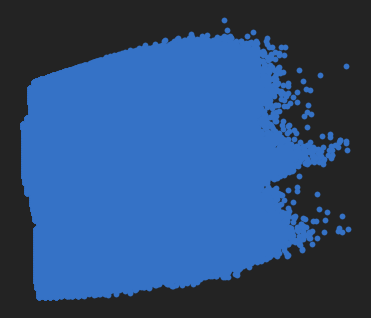

In [17]:
plot_2D(pca_results)
#plot_2D(umap_results)

## elbow method

--- elbow_method() ---
	--- 9.77 seconds: k=2 ---
	--- 9.85 seconds: k=3 ---
	--- 10.04 seconds: k=4 ---
	--- 9.79 seconds: k=5 ---
	--- 9.85 seconds: k=6 ---
	--- 17.52 seconds: k=7 ---
	--- 21.62 seconds: k=8 ---
	--- 20.79 seconds: k=9 ---
	--- 9.88 seconds: k=10 ---
	--- 17.77 seconds: k=11 ---
	--- 27.41 seconds: k=12 ---
	--- 20.80 seconds: k=13 ---
	--- 15.74 seconds: k=14 ---
	--- 10.15 seconds: k=15 ---
	--- 18.44 seconds: k=16 ---
	--- 10.46 seconds: k=17 ---
	--- 10.07 seconds: k=18 ---
	--- 22.06 seconds: k=19 ---
	--- 30.03 seconds: k=20 ---
--- elbow_method() completed in 302.0395 seconds ---
--- plot_elbow_method() ---


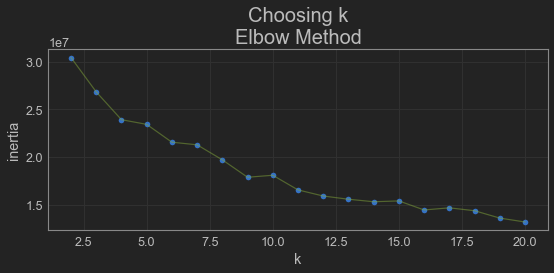

--- plot_elbow_method() completed in 0.1366 seconds


In [18]:
inertia = elbow_method(X_std, range(2,21), True)
plot_elbow_method(inertia, range(2,21))

## silhouette analysis

In [19]:
# double check input shape
X_std.shape

(3292455, 11)

In [20]:
# define sampling rate
sampling_rate = 0.01
num_samples = int(X_std.shape[0] * sampling_rate)
num_samples

32924

In [21]:
# sample the data for silhouette analysis
X_std_ = X_std[np.random.choice(X_std.shape[0], num_samples, replace=False)]

# execute pca
pca_results_ = run_pca(X_std_)

# execute umap
umap_results_ = run_umap(X_std_, 500, 0.1)
X_std_.shape

PCA start...
PCA completed in 0.048871 seconds!

UMAP start...
UMAP completed in 192.536081 seconds!



(32924, 11)

In [50]:
df_tmp = pd.DataFrame(X_std_)
df_tmp.columns = ['d4', 'd16', 'days_elapsed', 'reord1', 'num_items', 'ORDER_DAY_WEEKEND',
                  'ORDER_TIME_POST-PEAK', 'ORDER_TIME_PRE-PEAK', 'ORDER_NUMBER_Q25',
                  'ORDER_NUMBER_Q50', 'ORDER_NUMBER_Q75']
#df_tmp.head()
df_tmp.to_csv('instacart_unsupervised_model_11_features_post_one_hot_encoding_post_standardization_1_percent_sa.csv', index=False)

,d4,d16,days_elapsed,reord1,num_items,ORDER_DAY_WEEKEND,ORDER_TIME_POST-PEAK,ORDER_TIME_PRE-PEAK,ORDER_NUMBER_Q25,ORDER_NUMBER_Q50,ORDER_NUMBER_Q75
0,-0.230435,-0.892159,-0.471350,-0.888959,-0.492491,-0.727094,1.754232,-0.344237,-0.564457,1.730895,-0.592359
1,-0.933324,0.292882,-1.008100,-0.265520,-0.822671,1.375337,-0.570050,-0.344237,-0.564457,-0.577736,-0.592359
2,-0.933324,-0.299638,-1.115450,-1.096772,-0.987762,-0.727094,1.754232,-0.344237,-0.564457,-0.577736,1.688165
3,-0.230435,-0.892159,-0.471350,-0.681146,-1.152852,-0.727094,-0.570050,-0.344237,-0.564457,-0.577736,1.688165
4,0.121009,-0.299638,0.387451,-0.681146,-0.657581,1.375337,-0.570050,2.904977,-0.564457,1.730895,-0.592359


### kmeans

--- silhouette_analysis() ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3}
	--- calculated silhouette average across all samples (0.186587) in 14.501256465911865 seconds ---
	--- calculated silhouette score for each sample in 14.3376944065094 seconds ---
--- silhouette_plot() completed in 28.8559 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.017951 seconds! ---
	--- 4-cluster silhouette analysis completed in 28.9995 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4}
	--- calculated silhouette average across all samples (0.195842) in 14.1771240234375 seconds ---
	--- calculated silhouette score for each sample in 14.152188539505005 seconds ---
--- silhouette_plot() completed in 28.3483 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.019947 seconds! ---
	--- 5-cluster silhouette analysis completed in 28.6305 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4, 5}
	--- calculated silhouette avera

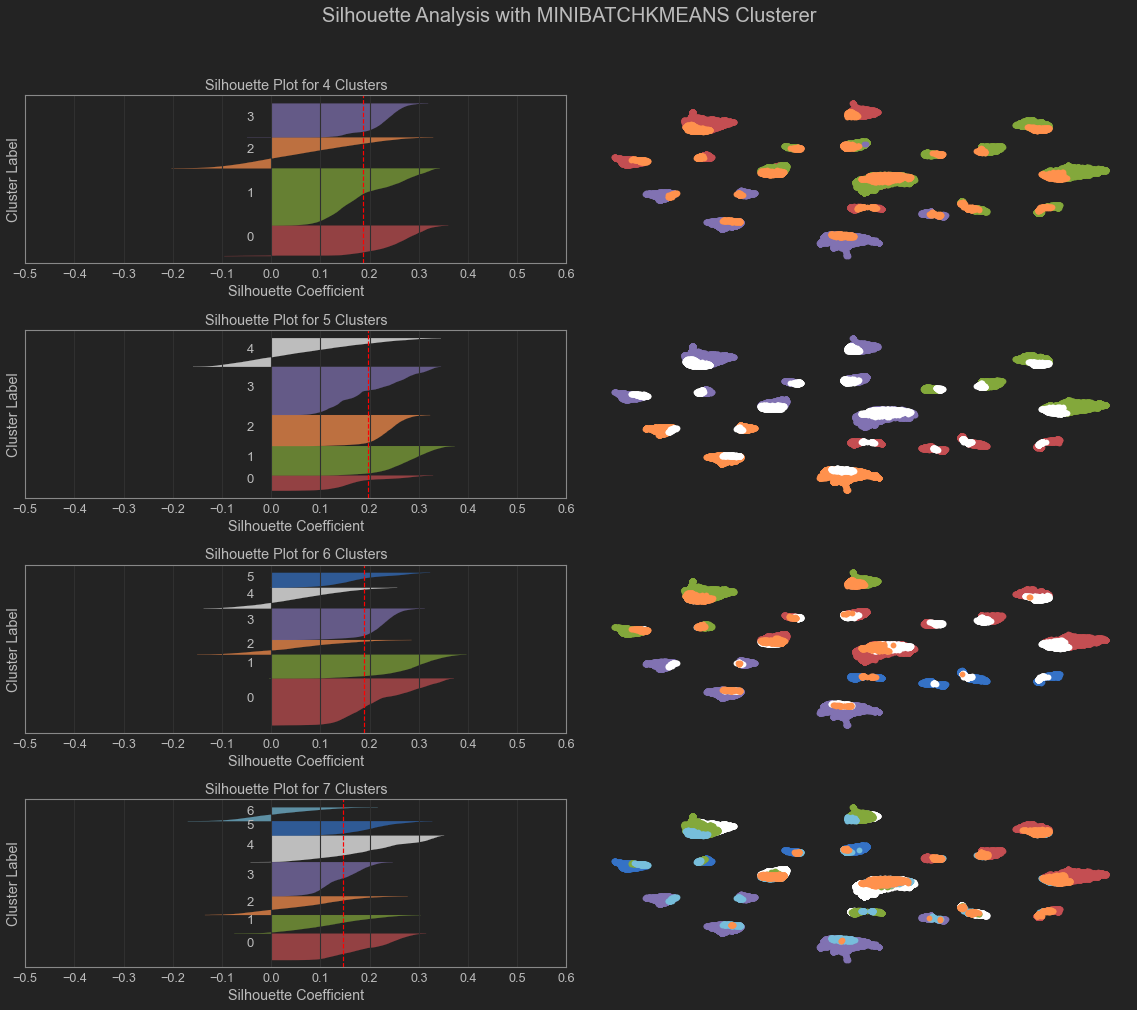

--- silhouette analysis() completed in 115.1663 seconds ---


In [22]:
#silhouette_analysis(X_std_, [4,5,6], 'MINIBATCHKMEANS', pca_results_)
silhouette_analysis(X_std_, [4,5,6,7], 'MINIBATCHKMEANS', umap_results_)

### agglomerative clustering

#### agglomerative-1 (complete/cosine)

--- silhouette_analysis() ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3}
	--- calculated silhouette average across all samples (0.053927) in 15.105643510818481 seconds ---
	--- calculated silhouette score for each sample in 14.644872903823853 seconds ---
--- silhouette_plot() completed in 29.7904 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.071807 seconds! ---
	--- 4-cluster silhouette analysis completed in 107.0034 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4}
	--- calculated silhouette average across all samples (0.093615) in 15.243274688720703 seconds ---
	--- calculated silhouette score for each sample in 17.824142456054688 seconds ---
--- silhouette_plot() completed in 33.0933 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.028923 seconds! ---
	--- 5-cluster silhouette analysis completed in 93.6346 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4, 5}
	--- calculated silhouette 

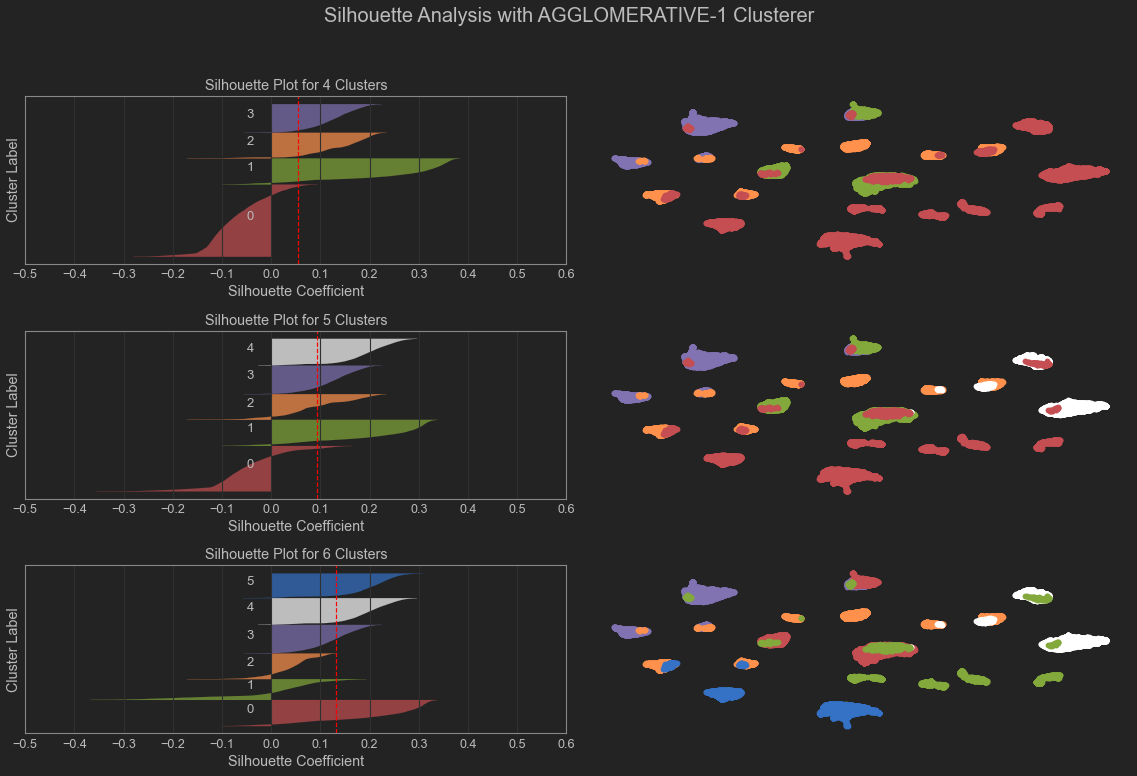

--- silhouette analysis() completed in 292.3405 seconds ---


In [23]:
#silhouette_analysis(X_std_, [4,5], 'AGGLOMERATIVE-1', pca_results_)
silhouette_analysis(X_std_, [4,5,6], 'AGGLOMERATIVE-1', umap_results_)

#### agglomerative-2 (ward/euclidean)

--- silhouette_analysis() ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3}
	--- calculated silhouette average across all samples (0.170159) in 15.005602359771729 seconds ---
	--- calculated silhouette score for each sample in 14.934239149093628 seconds ---
--- silhouette_plot() completed in 29.9777 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.060837 seconds! ---
	--- 4-cluster silhouette analysis completed in 101.7163 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4}
	--- calculated silhouette average across all samples (0.173714) in 14.691180944442749 seconds ---
	--- calculated silhouette score for each sample in 14.598262786865234 seconds ---
--- silhouette_plot() completed in 29.3114 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.023938 seconds! ---
	--- 5-cluster silhouette analysis completed in 96.7200 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4, 5}
	--- calculated silhouette 

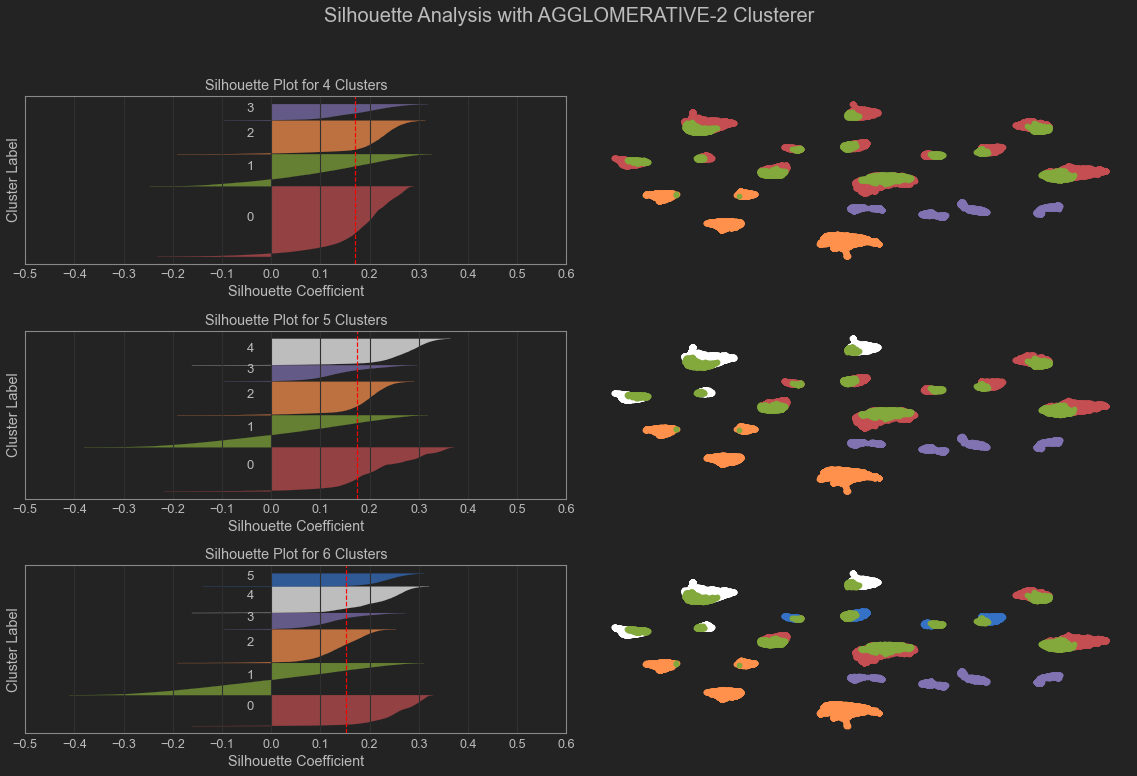

--- silhouette analysis() completed in 301.8530 seconds ---


In [24]:
#silhouette_analysis(X_std_, [4,5,6], 'AGGLOMERATIVE-2', pca_results_)
silhouette_analysis(X_std_, [4,5,6], 'AGGLOMERATIVE-2', umap_results_)

#### agglomerative-3 (average/cosine)

--- silhouette_analysis() ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3}
	--- calculated silhouette average across all samples (0.183462) in 14.964020490646362 seconds ---
	--- calculated silhouette score for each sample in 14.49427604675293 seconds ---
--- silhouette_plot() completed in 29.4952 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.055851 seconds! ---
	--- 4-cluster silhouette analysis completed in 115.9262 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4}
	--- calculated silhouette average across all samples (0.166024) in 14.776521682739258 seconds ---
	--- calculated silhouette score for each sample in 14.270873546600342 seconds ---
--- silhouette_plot() completed in 29.0913 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.062831 seconds! ---
	--- 5-cluster silhouette analysis completed in 100.1481 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4, 5}
	--- calculated silhouette 

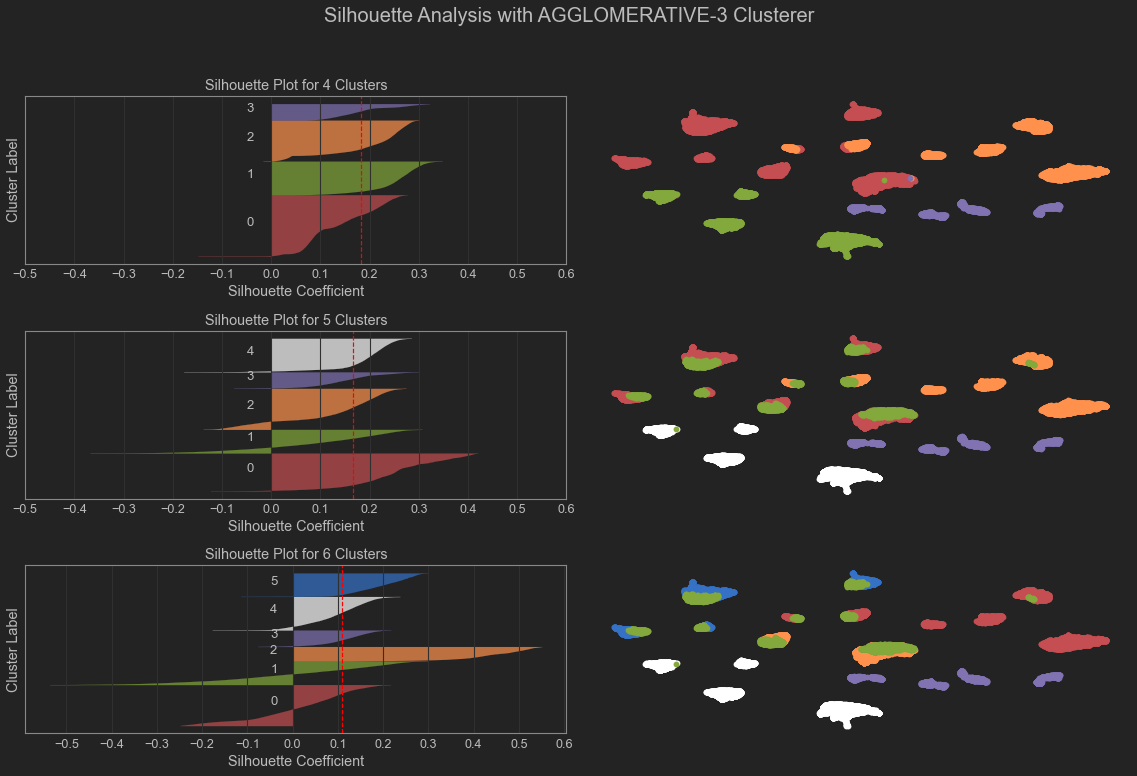

--- silhouette analysis() completed in 312.6182 seconds ---


In [25]:
#silhouette_analysis(X_std_, [4,5,6], 'AGGLOMERATIVE-3', pca_results_)
silhouette_analysis(X_std_, [4,5,6], 'AGGLOMERATIVE-3', umap_results_)

### gmm

--- silhouette_analysis() ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3}
	--- calculated silhouette average across all samples (0.150079) in 14.42944860458374 seconds ---
	--- calculated silhouette score for each sample in 14.556110858917236 seconds ---
--- silhouette_plot() completed in 29.0025 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.017952 seconds! ---
	--- 4-cluster silhouette analysis completed in 31.5998 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4}
	--- calculated silhouette average across all samples (0.162078) in 14.45438289642334 seconds ---
	--- calculated silhouette score for each sample in 14.32472825050354 seconds ---
--- silhouette_plot() completed in 28.7961 seconds ---
--- plot_2D() ---
--- plot_2D() completed in 0.022939 seconds! ---
	--- 5-cluster silhouette analysis completed in 30.8765 seconds ---
--- silhouette_plot() ---
	--- cluster_solution = {0, 1, 2, 3, 4, 5}
	--- calculated silhouette aver

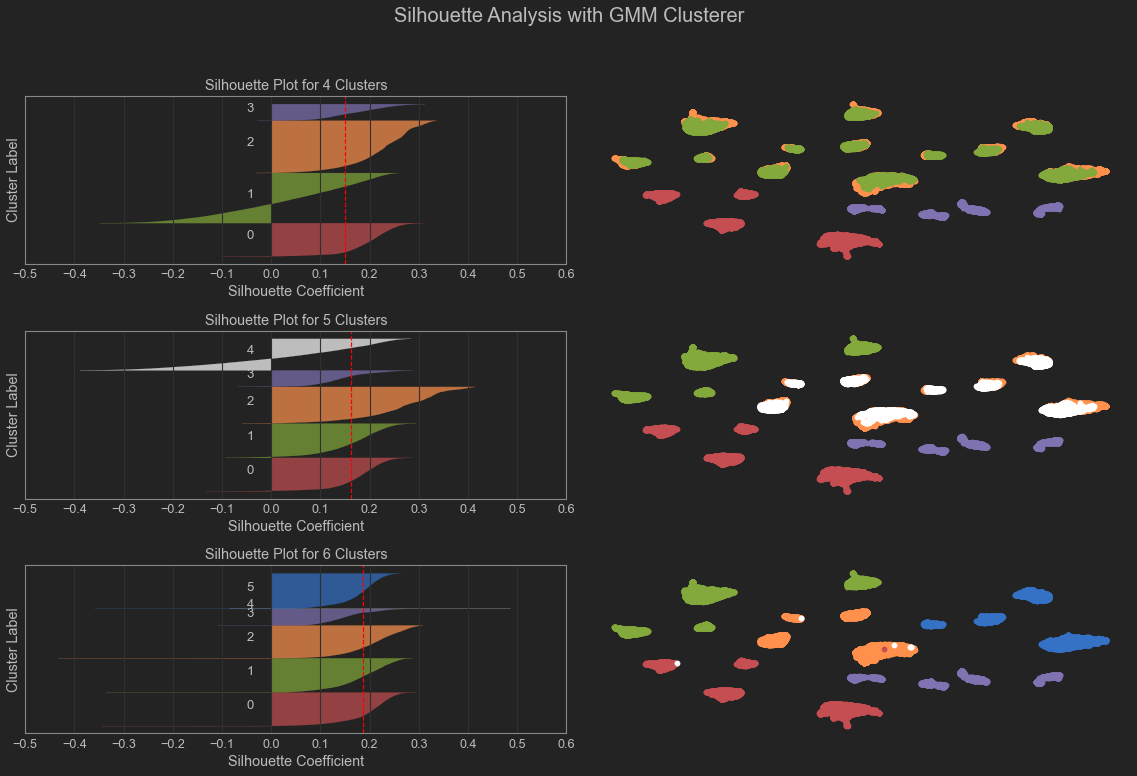

--- silhouette analysis() completed in 93.4485 seconds ---


In [27]:
#silhouette_analysis(X_std_, [4,5,6], 'GMM', pca_results_)
silhouette_analysis(X_std_, [4,5,6], 'GMM', umap_results_)

## final clustering

In [28]:
# double check input shape
X_std.shape

(3292455, 11)

In [29]:
print('--- Kmeans Start ---')
time_start = time.time()

# define clustering algorithm
clusterer = KMeans(n_clusters=5, n_jobs=4)

# determine cluster labels
cluster_labels = clusterer.fit_predict(X_std)

print(f'--- Completed in {time.time() - time_start} seconds ---')
pd.DataFrame(cluster_labels)

--- Kmeans Start ---
--- Completed in 58.62806940078735 seconds ---


,0
0,3
1,3
2,4
3,3
4,2
...,...
3292450,2
3292451,1
3292452,0
3292453,1


# CLUSTER EVALUATION
---

## apply labels

In [30]:
# add cluster labels to dataset
df_clustered = df_orders_pvt.copy()
df_clustered['Cluster'] = cluster_labels

In [31]:
# check how many clusters assigned
print('--- Number of unique clusters ---')
print(df_clustered.Cluster.unique())

print()

# check how many observations in each cluster
print('--- Count per cluster ---')
print(df_clustered.Cluster.value_counts())


--- Number of unique clusters ---
[3 4 2 0 1]

--- Count per cluster ---
2    1095427
4     665487
1     615568
0     592792
3     323181
Name: Cluster, dtype: int64


In [32]:
df_clustered.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour,d1,d2,d3,d4,...,d16,d17,d18,d19,d20,d21,days_elapsed,reord1,num_items,Cluster
0,2539329,1,prior,1,2,8,0,0,0,0,...,1,1,0,2,0,0,0.0,0,5,3
1,2398795,1,prior,2,3,7,0,0,0,1,...,0,0,0,3,0,0,15.0,3,6,3
2,473747,1,prior,3,3,12,0,0,0,0,...,1,0,0,2,0,0,21.0,3,5,4
3,2254736,1,prior,4,4,7,0,0,0,0,...,1,1,0,2,0,0,29.0,5,5,3
4,431534,1,prior,5,4,15,0,0,0,4,...,1,0,0,2,0,0,28.0,5,8,2


In [33]:
df_clustered.groupby('Cluster')[['d4','d16']].describe()

d4                                                      d16  \
             count      mean       std  min  25%  50%  75%   max      count   
Cluster                                                                       
0         592792.0  6.048597  3.358754  0.0  4.0  6.0  8.0  24.0   592792.0   
1         615568.0  1.815478  1.928556  0.0  0.0  1.0  3.0  13.0   615568.0   
2        1095427.0  1.663456  1.798935  0.0  0.0  1.0  3.0  13.0  1095427.0   
3         323181.0  2.344757  2.432484  0.0  0.0  2.0  4.0  20.0   323181.0   
4         665487.0  2.194817  2.362009  0.0  0.0  2.0  3.0  17.0   665487.0   

                                                       
             mean       std  min  25%  50%  75%   max  
Cluster                                                
0        3.338763  2.092065  0.0  2.0  3.0  4.0  26.0  
1        1.059522  1.198932  0.0  0.0  1.0  2.0  10.0  
2        0.959332  1.123507  0.0  0.0  1.0  2.0   9.0  
3        1.377163  1.492333  0.0  0.0  1.0  2.0  13.0  
4        1.247360  1.400405  0.0  0.0  1.0  2.0  12.0

In [34]:
df_clustered.groupby('Cluster')[['num_items','reord1']].describe()

num_items                                                    \
             count       mean       std  min   25%   50%   75%   max   
Cluster                                                                
0         592792.0  17.736823  4.285496  7.0  14.0  18.0  21.0  26.0   
1         615568.0   6.771388  4.056040  0.0   4.0   6.0  10.0  26.0   
2        1095427.0   6.282223  3.794613  0.0   3.0   6.0   9.0  26.0   
3         323181.0   8.046510  5.229366  0.0   4.0   7.0  11.0  26.0   
4         665487.0   8.132317  5.198800  0.0   4.0   7.0  11.0  26.0   

            reord1                                                    
             count       mean       std  min   25%   50%   75%   max  
Cluster                                                               
0         592792.0  12.579416  4.514793  0.0  10.0  12.0  15.0  26.0  
1         615568.0   4.517004  3.064882  0.0   2.0   4.0   7.0  19.0  
2        1095427.0   3.929594  2.715720  0.0   2.0   4.0   6.0  17.0  
3         323181.0   4.753089  3.940600  0.0   2.0   4.0   7.0  24.0  
4         665487.0   1.950976  2.411482  0.0   0.0   1.0   3.0  17.0

In [35]:
df_clustered.groupby('Cluster')['days_elapsed'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,592792.0,10.320463,8.125150,0.0,5.0,7.0,14.0,30.0
1,615568.0,10.138574,8.401695,0.0,4.0,7.0,14.0,30.0
2,1095427.0,10.051749,9.170659,0.0,3.0,7.0,14.0,30.0
3,323181.0,10.248050,9.082711,0.0,4.0,7.0,14.0,30.0
4,665487.0,11.314042,11.207281,0.0,0.0,7.0,21.0,30.0


In [39]:
print(df_clustered.groupby('Cluster').order_dow.agg(lambda x:x.value_counts().index[0]))
print(df_clustered.groupby('Cluster').order_hour.agg(lambda x:x.value_counts().index[0]))

Cluster
0    0
1    1
2    1
3    1
4    0
Name: order_dow, dtype: int64
Cluster
0    10
1    10
2    10
3     8
4    15
Name: order_hour, dtype: int64


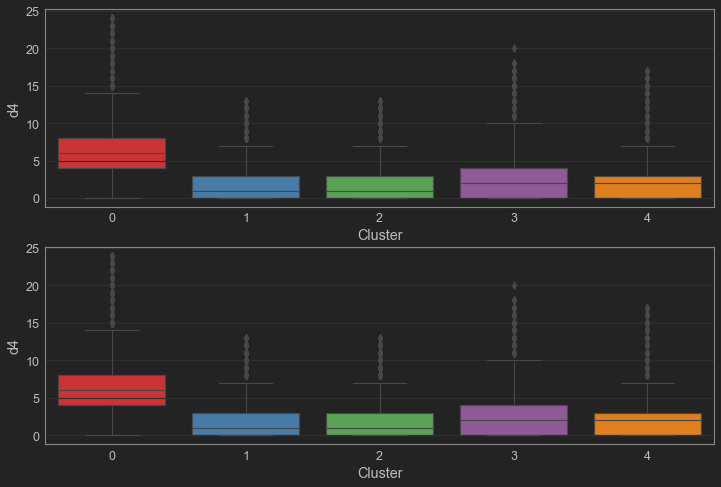

In [40]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,8)
plt.subplot(2,1,1)
sns.boxplot(data=df_clustered, x='Cluster', y='d4', palette='Set1')
plt.subplot(2,1,2)
sns.boxplot(data=df_clustered[df_clustered.order_number>0], x='Cluster', y='d4', palette='Set1')

plt.show()

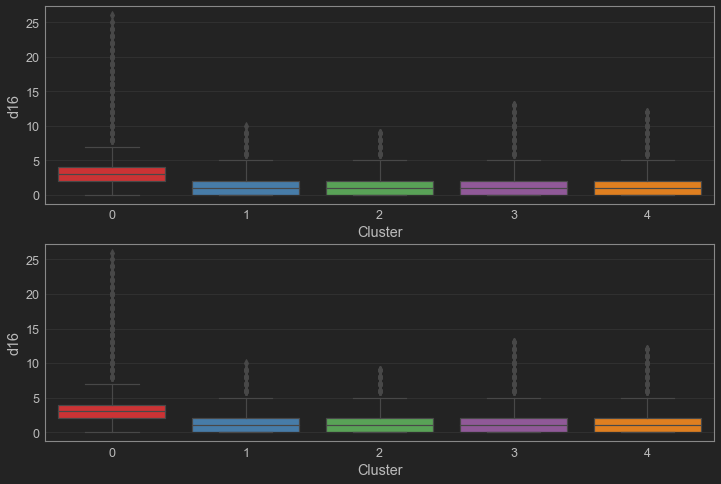

In [41]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,8)
plt.subplot(2,1,1)
sns.boxplot(data=df_clustered, x='Cluster', y='d16', palette='Set1')
plt.subplot(2,1,2)
sns.boxplot(data=df_clustered[df_clustered.order_number>0], x='Cluster', y='d16', palette='Set1')

plt.show()

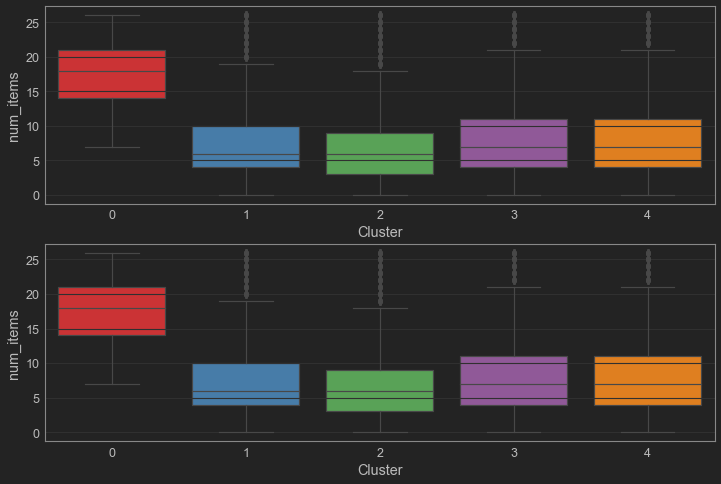

In [42]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,8)
plt.subplot(2,1,1)
sns.boxplot(data=df_clustered, x='Cluster', y='num_items', palette='Set1')
plt.subplot(2,1,2)
sns.boxplot(data=df_clustered[df_clustered.order_number>0], x='Cluster', y='num_items', palette='Set1')

plt.show()

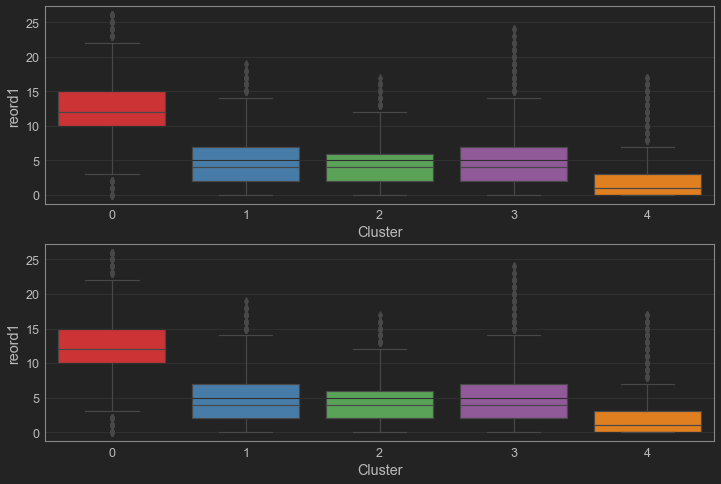

In [43]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,8)
plt.subplot(2,1,1)
sns.boxplot(data=df_clustered, x='Cluster', y='reord1', palette='Set1')
plt.subplot(2,1,2)
sns.boxplot(data=df_clustered[df_clustered.order_number>0], x='Cluster', y='reord1', palette='Set1')

plt.show()

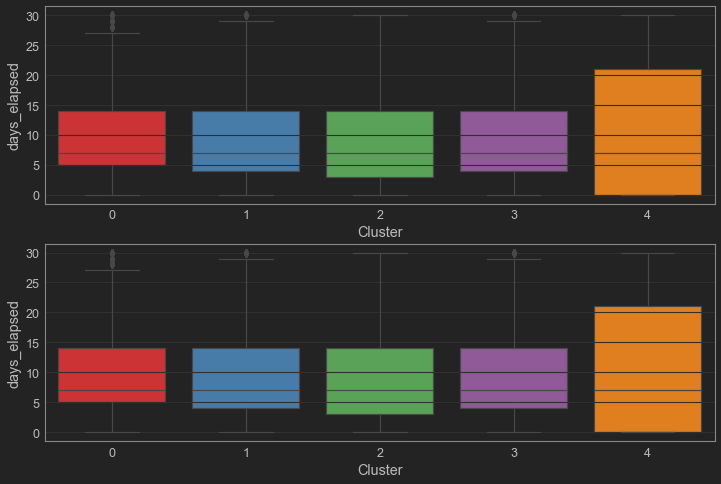

In [44]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,8)
plt.subplot(2,1,1)
sns.boxplot(data=df_clustered, x='Cluster', y='days_elapsed', palette='Set1')
plt.subplot(2,1,2)
sns.boxplot(data=df_clustered[df_clustered.order_number>0], x='Cluster', y='days_elapsed', palette='Set1')

plt.show()

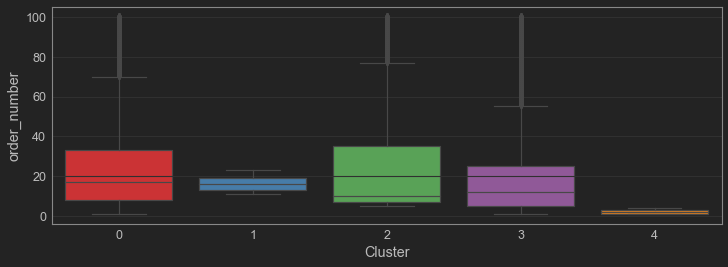

In [45]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,4)
sns.boxplot(data=df_clustered, x='Cluster', y='order_number', palette='Set1')


plt.show()

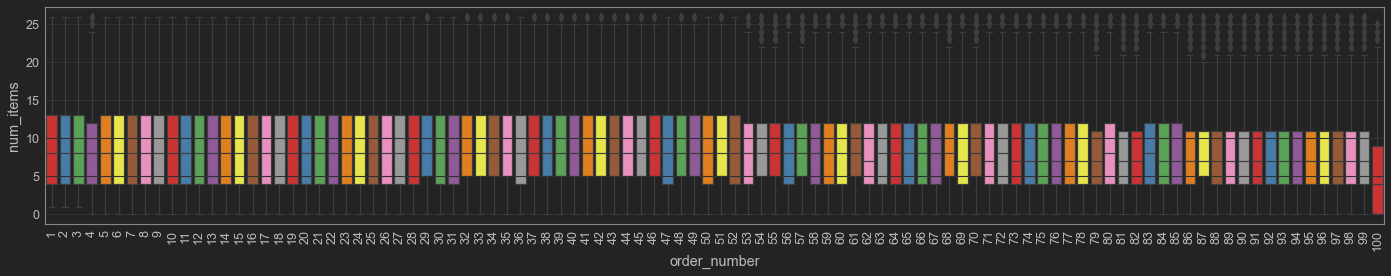

In [46]:
# set figure parameters
plt.rcParams['figure.figsize'] = (24,4)
sns.boxplot(data=df_clustered, x='order_number', y='num_items', palette='Set1')

plt.xticks(rotation='vertical')

plt.show()

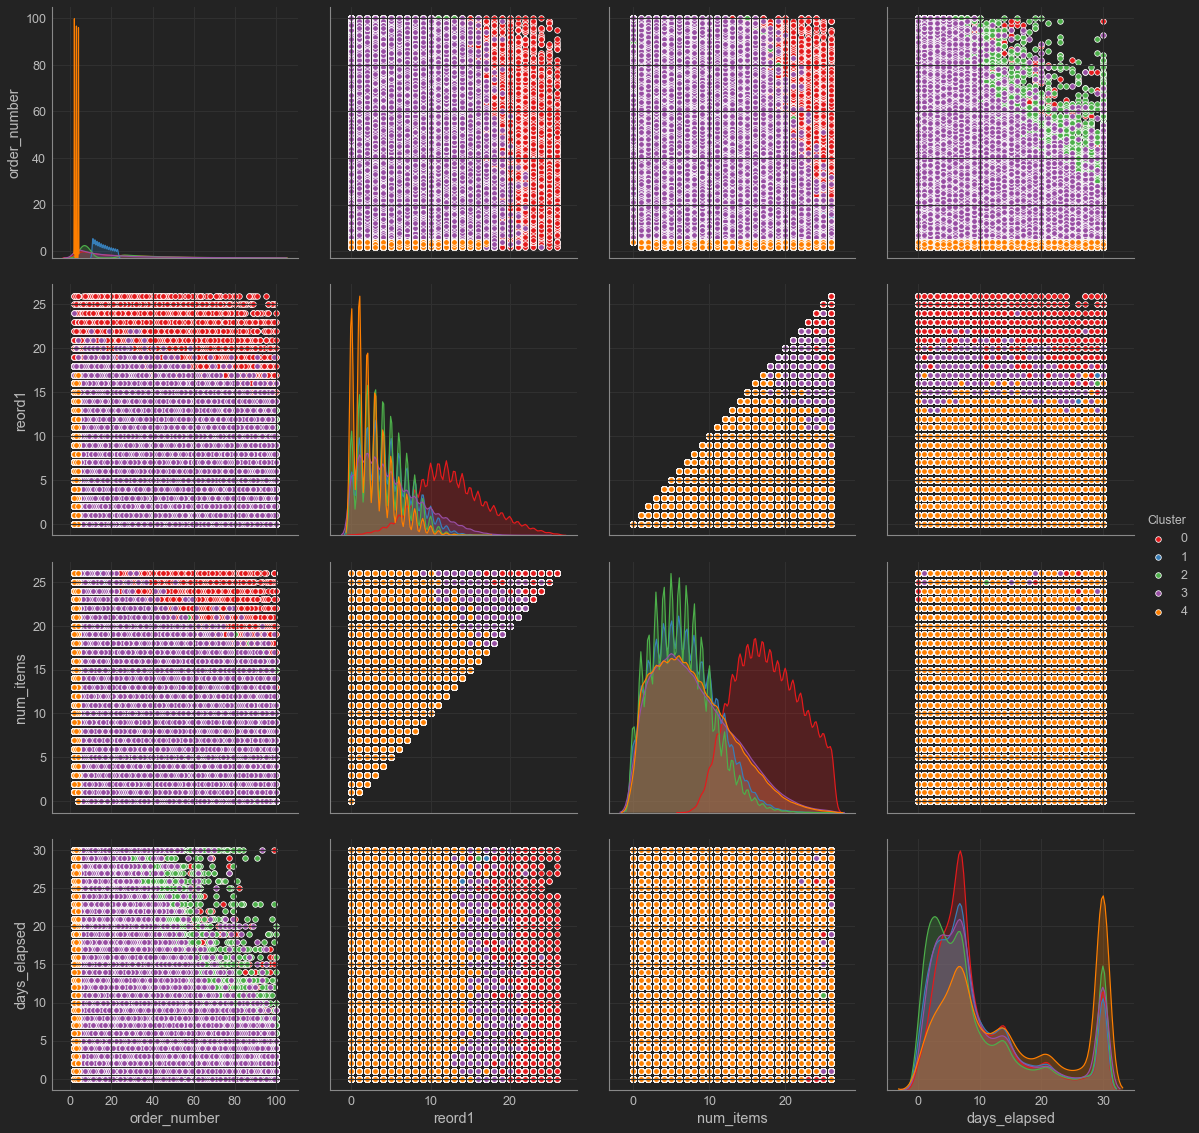

In [47]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,4)

# sample data (w/no replacement and random_state not set) to reduce compute time
my_data = df_clustered[df_clustered.order_number > 1].sample(frac=0.25)

# plot regplot
plot_ = sns.pairplot(data=my_data, vars=['order_number','reord1','num_items','days_elapsed'], hue='Cluster', palette='Set1', height=4)

plt.show()

In [ ]:
# set figure parameters
plt.rcParams['figure.figsize'] = (12,4)
sns.distplot(df_clustered[df_clustered.Cluster==0].num_items, label='Cluster_0')
sns.distplot(df_clustered[df_clustered.Cluster==1].num_items, label='Cluster_1')
sns.distplot(df_clustered[df_clustered.Cluster==2].num_items, label='Cluster_2')
sns.distplot(df_clustered[df_clustered.Cluster==3].num_items, label='Cluster_3')
sns.distplot(df_clustered[df_clustered.Cluster==4].num_items, label='Cluster_4')

plt.show()